# SWAST Forecasting Tool

An ensemble of Regression with ARIMA Errors and Facebook Prophet

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

check statsmodels version

In [43]:
import statsmodels as sm
print(sm.__version__)

import os

os.getcwd()

0.11.1


'/home/tom/Documents/code/swast-forecast-tool'

In [44]:
from swast_forecast.utility import (default_ensemble,
                                    forecast, 
                                    multi_region_forecast, 
                                    built_in_synthetic_data)

## Constants

## Read in the data

In [45]:
clean = built_in_synthetic_data()
clean.head()

,trust1_syn,trust2_syn
actual_dt,,
2014-01-01,454,372
2014-01-02,358,280
2014-01-03,366,286
2014-01-04,337,313
2014-01-05,338,284


## Creating and fitting an Ensemble model to a region

The easy way to create an ensemble model is to call the `default_ensemble()` function form the utility module.  This returns the best known forecasting model.

In [46]:
model = default_ensemble()
model

ProphetARIMAEnsemble(order=(1, 1, 3), seasonal_order=(1, 0, 1, 7), prophet_default_alpha={self.alpha})

The code above informs us that the ensemble includes a Regression model with ARIMA errors with parameters (1, 1, 3)(1, 0, 1, 7).  By default a Prophet model will create a 80\% prediction interval 100(1-alpha)

To fit we call the `.fit()` method and pass in a `pd.Series` (or `pd.DataFrame`) that contains the historical observations.  By default you do not need to pass in holidays.  The ensemble will model new years day automatically (via Prophet's holidays function and as a dummy variable in the Regression with ARIMA errors).

In [47]:
#example - fitting Wiltshire - this will take a few seconds.
model.fit(clean['trust1_syn'])

## Forecasting an individual region.

Use the `.predict()` method to make a forecast.  The method takes 3 parameters:

* **horizon**: int - the forecast horizon e.g. 84 days
* **alpha**: float, optional (default=0.05) - a value between 0 and 1 and used to construct a 100(1 - alpha) prediction interval. E.g. alpha=0.2 returns a 80\% interval.  
* **return_all_models**: bool, optional (default=False). If sets to true returns the ensemble prediction AND the Prophet and Regression predictions.

In [48]:
#example 1: predict 7 days ahead - remember we have fitted Wiltshire training data.
forecast_frame = model.predict(horizon=7)
forecast_frame

,yhat,yhat_lower_95,yhat_upper95
ds,,,
2020-01-01,483.228654,449.681825,517.501546
2020-01-02,399.154484,365.032580,433.443876
2020-01-03,403.186663,368.176346,437.129631
2020-01-04,424.009261,389.819275,459.289341
2020-01-05,420.580550,385.690555,455.715150
2020-01-06,407.306482,371.531532,442.592187
2020-01-07,392.407264,357.668120,427.055290


The method returns a `pd.DataFrame` containing mean forecast (yhat) and an upper and lower prediction interval.  The code below demonstrates how to return predictions from both the ARIMA and Prophet models.  We will also return a different prediction interval.

In [49]:
#example 2: predict 7 days ahead, return 80% PI and individual model preds
forecast_frame = model.predict(horizon=7, alpha=0.2, return_all_models=True)
forecast_frame

,yhat,yhat_lower_80,yhat_upper80,arima_mean,arima_lower_80,arima_upper_80,prophet_mean,prophet_lower_80,prophet_upper_80
ds,,,,,,,,,
2020-01-01,483.228654,460.399315,504.427639,478.461571,456.823686,500.099456,487.995737,463.974944,508.755821
2020-01-02,399.154484,375.782301,420.921360,404.308921,381.613217,427.004625,394.000046,369.951385,414.838095
2020-01-03,403.186663,380.122411,426.531179,408.034377,384.844496,431.224258,398.338950,375.400326,421.838101
2020-01-04,424.009261,400.956137,446.908917,427.915324,404.405985,451.424663,420.103197,397.506289,442.393171
2020-01-05,420.580550,398.369566,443.471270,425.293454,401.559746,449.027162,415.867647,395.179386,437.915379
2020-01-06,407.306482,385.388683,430.004443,413.438024,389.534225,437.341822,401.174939,381.243140,422.667064
2020-01-07,392.407264,370.958182,415.920163,399.936205,375.894595,423.977815,384.878324,366.021770,407.862510


## An 'all in one' forecast function

As an alternative to the above the `utility` module contains a convenience function called `forecast`.  This is an all-in-one function.  Just pass in your training data (for a single time series) and horizon.

In [50]:
forecast(clean['trust2_syn'], 
         horizon=365, 
         alpha=0.2,
         return_all_models=False)


,yhat,yhat_lower_80,yhat_upper80
ds,,,
2020-01-01,417.046162,398.480458,435.209888
2020-01-02,346.195936,326.706820,364.667204
2020-01-03,351.526920,332.632039,370.330537
2020-01-04,368.416428,349.794235,387.674724
2020-01-05,365.933441,346.941027,385.340333
...,...,...,...
2020-12-26,387.699087,356.718634,418.044011
2020-12-27,385.386028,354.432477,417.918686
2020-12-28,372.920548,341.356313,404.472659


## Forecasting multiple regions in one go.

If there are multiple regions to forecast put all of the training data into the same frame (see `clean`) and pass this to the `multi_region_forecast()` function from the `utility` module.

This is an efficient function as it runs the forecasts in parrallel across your CPU cores.  E.g. if you have a 4 cores then 4 regions will be forecast simultaneously.  This will reduce model run time (assuming you have more than one Core).

In [54]:
#note depending on your machine this will take 20 seconds to run.
forecasts = multi_region_forecast(y_train=clean.iloc[-84:], horizon=365)

In [55]:
#the function returns a list of pd.DataFrame's
type(forecasts)

list

In [56]:
#results for trust1_syn
forecasts[0]

,yhat,yhat_lower_95,yhat_upper95
ds,,,
2020-01-01,403.979607,374.889865,433.878640
2020-01-02,418.907898,389.825120,447.780014
2020-01-03,414.208289,384.659119,444.139333
2020-01-04,426.194336,396.263630,456.119254
2020-01-05,427.284939,397.631594,456.847104
...,...,...,...
2020-12-26,512.327404,430.792533,596.499527
2020-12-27,514.261738,432.305720,599.103691
2020-12-28,509.863303,427.640590,593.912621


In [57]:
#results for trust2_syn is at index 1 etc.
forecasts[1]

,yhat,yhat_lower_95,yhat_upper95
ds,,,
2020-01-01,358.996250,334.274761,383.748430
2020-01-02,357.630992,332.529766,382.305824
2020-01-03,366.287902,341.352520,391.277667
2020-01-04,373.888315,349.216802,398.770930
2020-01-05,371.652474,346.678438,395.934311
...,...,...,...
2020-12-26,422.913012,377.901057,469.410454
2020-12-27,423.081719,377.312151,469.026779
2020-12-28,414.847951,368.142280,460.983253


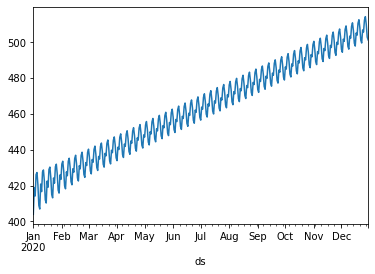

In [59]:
forecasts[0]['yhat'].plot()

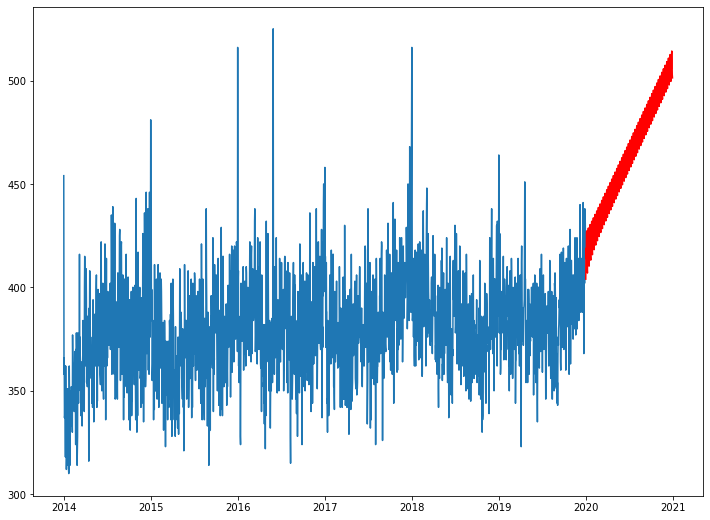

In [60]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
ax.plot(clean['trust1_syn'])
ax.plot(forecasts[0]['yhat'], color='red')